In [107]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import DataLoader

from dataset import SiameseDataset

In [108]:
def normalize_heatmap(heatmap):
    heatmap -= heatmap.min()
    heatmap /= heatmap.max()
    return heatmap

def generate_heatmap(image_shape, landmarks, sigma=1.0, scale=1.0):
    k, H, W = image_shape
    heatmaps = np.zeros((k, H, W), dtype=np.float32)
    
    for idx, (x, y) in enumerate(landmarks):
        x_scaled = int(np.round(x * scale))
        y_scaled = int(np.round(y * scale))
        
        x_range = np.arange(0, W)
        y_range = np.arange(0, H)
        X, Y = np.meshgrid(x_range, y_range)
        
        heatmap = (1 / (2 * np.pi * sigma ** 2)) * np.exp(-((X - x_scaled) ** 2 + (Y - y_scaled) ** 2) / (2 * sigma ** 2))
        heatmaps[idx] = normalize_heatmap(heatmap)
    
    return heatmaps

In [109]:
def overlay_heatmaps(image, heatmaps, alpha=0.5, colormap=cv2.COLORMAP_HOT):
    overlayed_image = image.astype(np.float32)

    for heatmap in heatmaps:
        heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        heatmap_resized = cv2.normalize(heatmap_resized, None, 0, 1, cv2.NORM_MINMAX)
        heatmap_resized = np.power(heatmap_resized, 0.5)  # Increase contrast
        
        heatmap_normalized = (heatmap_resized * 255).astype(np.uint8)
        heatmap_colored = cv2.applyColorMap(heatmap_normalized, colormap).astype(np.float32)

        overlayed_image = cv2.addWeighted(overlayed_image, 1.0, heatmap_colored, alpha, 0)

    overlayed_image = np.clip(overlayed_image, 0, 255).astype(np.uint8)

    return overlayed_image

In [110]:
def apply_fifa_augmentation(image, landmarks, patch_size_start, epochs, interval):
    img_aug = image.copy()
    h, w, _ = image.shape
    
    for epoch in range(epochs):
        k = epoch // interval
        patch_size = max(1, patch_size_start - k)
        half_patch = patch_size // 2
        
        for (x, y) in landmarks:
            top_left = (int(x - half_patch), int(y - half_patch))
            bottom_right = (int(x + half_patch), int(y + half_patch))
            
            if (0 <= top_left[0] < w and 0 <= top_left[1] < h and
                0 <= bottom_right[0] < w and 0 <= bottom_right[1] < h):
                cv2.rectangle(img_aug, top_left, bottom_right, (0, 0, 0), -1)
    
    return img_aug

In [111]:
dataset = SiameseDataset(root_dir='archive/ibug_300W_large_face_landmark_dataset/afw')

In [112]:
img, imgMirror, points = dataset.__getitem__(1)

In [113]:
img_fifa_augmented = apply_fifa_augmentation(img, points, patch_size_start=10, epochs=5, interval=1)

In [114]:
heatmaps = generate_heatmap((len(points), img.shape[0], img.shape[1]), points)

<ipython-input-108-de7afba518b4>:3: RuntimeWarning: invalid value encountered in divide
  heatmap /= heatmap.max()


In [115]:
img_with_heatmaps = overlay_heatmaps(img, heatmaps, alpha=0.6)

<ipython-input-109-b86d357e295f>:9: RuntimeWarning: invalid value encountered in cast
  heatmap_normalized = (heatmap_resized * 255).astype(np.uint8)


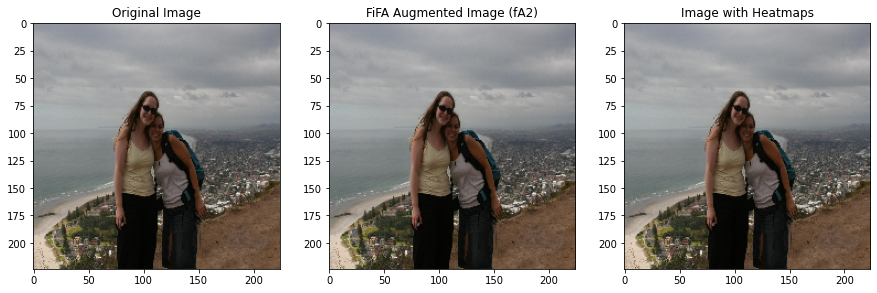

In [116]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img_fifa_augmented, cv2.COLOR_BGR2RGB))
plt.title('FiFA Augmented Image (fA2)')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_with_heatmaps, cv2.COLOR_BGR2RGB))
plt.title('Image with Heatmaps')

plt.show()

In [117]:
class LandmarkModel(nn.Module):
    def __init__(self, input_channels=3, num_landmarks=68):
        super(LandmarkModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to handle variable sizes
        self.fc1 = nn.Linear(128, 1000)
        self.fc2 = nn.Linear(1000, num_landmarks * 2)  # Output landmarks

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.pool(x)  # Adaptive pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, 68, 2).float()  # Reshape to [batch_size, 68, 2]

In [118]:
def train_model(model, dataloader, criterion, optimizer, epochs=25):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        
        for inputs, _, landmarks in dataloader:
            inputs = inputs.permute(0, 3, 1, 2).float().to(device)  # Convert images to [B, C, H, W] and move to device
            landmarks = landmarks.float().to(device)  # Ensure landmarks are Float
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, landmarks)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch}/{epochs} - Loss: {epoch_loss:.4f}')
        print(f"Model output dtype: {outputs.dtype}")
        print(f"Landmarks dtype: {landmarks.dtype}")
        print(f"Loss dtype: {loss.dtype}")
    
    return model

In [119]:
# Initialize DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

# Initialize model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LandmarkModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
trained_model = train_model(model, dataloader, criterion, optimizer, epochs=25)

Epoch 0/25 - Loss: 403807.0855
Model output dtype: torch.float32
Landmarks dtype: torch.float32
Loss dtype: torch.float32
Epoch 1/25 - Loss: 293091.1104
Model output dtype: torch.float32
Landmarks dtype: torch.float32
Loss dtype: torch.float32
Epoch 2/25 - Loss: 246549.6260
Model output dtype: torch.float32
Landmarks dtype: torch.float32
Loss dtype: torch.float32
Epoch 3/25 - Loss: 252806.9761
Model output dtype: torch.float32
Landmarks dtype: torch.float32
Loss dtype: torch.float32
Epoch 4/25 - Loss: 245656.6416
Model output dtype: torch.float32
Landmarks dtype: torch.float32
Loss dtype: torch.float32
Epoch 5/25 - Loss: 251087.5524
Model output dtype: torch.float32
Landmarks dtype: torch.float32
Loss dtype: torch.float32
Epoch 6/25 - Loss: 240046.4415
Model output dtype: torch.float32
Landmarks dtype: torch.float32
Loss dtype: torch.float32
Epoch 7/25 - Loss: 248678.1333
Model output dtype: torch.float32
Landmarks dtype: torch.float32
Loss dtype: torch.float32
Epoch 8/25 - Loss: 23953

In [120]:
# Save the model
torch.save(trained_model.state_dict(), 'landmark_model.pth')

# Load the model (for inference later)
model.load_state_dict(torch.load('landmark_model.pth'))
model.eval()

<ipython-input-120-e0abc7b64ce4>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('landmark_model.pth'))


LandmarkModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=136, bias=True)
)